In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df=pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X=df.drop('Class',axis=1)
y=df['Class']

print(f"Shape of X : {X.shape}")
print(f"Shape of y : {y.shape}")

Shape of X : (284807, 30)
Shape of y : (284807,)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [6]:
#Lightgbm tuning
from sklearn.metrics import make_scorer, average_precision_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve, precision_score, recall_score, f1_score, 
                            roc_auc_score, average_precision_score)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [7]:
lgbm = LGBMClassifier(class_weight="balanced", random_state=42,n_jobs=-1, n_estimators=1000, learning_rate=0.03,
                     subsample=0.6, max_depth=7, colsample_bytree=0.6, reg_lambda=0.1, reg_alpha=0.1)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.03
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [8]:
y_pred_lgb=lgbm.predict(X_test)
y_pred_proba_lgb=lgbm.predict_proba(X_test)[:,1]

print("\nLightGBM Model Evaluation")
print(classification_report(y_test, y_pred_lgb))

precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_pred_proba_lgb)
auprc_lgb= auc(recall_lgb, precision_lgb)
print(f"AUPRC: {auprc_lgb:.4f}")

roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"ROC AUC: {roc_auc_lgb:.4f}")

print(confusion_matrix(y_test, y_pred_lgb))


LightGBM Model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8851
ROC AUC: 0.9792
[[56853    11]
 [   15    83]]


In [9]:
#lgbm threeshold
y_pred_lgb=lgbm.predict(X_test)
y_pred_proba_lgb=lgbm.predict_proba(X_test)[:,1]

y_pred_lgb_thre=(y_pred_proba_lgb>=0.50).astype(int)

print("\nLightGBM Model Evaluation")
print(classification_report(y_test, y_pred_lgb_thre))

print(confusion_matrix(y_test, y_pred_lgb_thre))


LightGBM Model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56853    11]
 [   15    83]]


In [10]:
#Xgboost 
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight:", scale_pos_weight)

xgb = XGBClassifier(random_state=42, eval_metric="aucpr", scale_pos_weight=scale_pos_weight, n_jobs=-1, n_estimators=1000, learning_rate=0.03,
                   reg_lambda=0.1, reg_alpha=0.1, max_depth=7, gamma=0.2, colsample_bytree=0.8)

xgb.fit(X_train, y_train)

scale_pos_weight: 577.2868020304569


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [11]:
y_pred_xgb=xgb.predict(X_test)
y_pred_proba_xgb=xgb.predict_proba(X_test)[:,1]

print("\nXGB model Evaluation")
print(classification_report(y_test, y_pred_xgb))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
auprc_xgb= auc(recall_xgb, precision_xgb)
print(f"AUPRC: {auprc_xgb:.4f}")

roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC AUC: {roc_auc_xgb:.4f}")

print(confusion_matrix(y_test, y_pred_xgb))


XGB model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUPRC: 0.8817
ROC AUC: 0.9744
[[56853    11]
 [   15    83]]


In [12]:
# ensembling : light and xgb
y_pred_lgbm=np.array(y_pred_proba_lgb)
y_pred_xgbb=np.array(y_pred_proba_xgb)

y_pred_en_2=(y_pred_lgbm + y_pred_xgbb)/2

# print(classification_report(y_test, y_pred_en_2))

precision_en2, recall_en2, _ = precision_recall_curve(y_test, y_pred_en_2)
auprc_en2= auc(recall_en2, precision_en2)
print(f"AUPRC: {auprc_en2:.4f}")

roc_auc_en2 = roc_auc_score(y_test, y_pred_en_2)
print(f"ROC AUC: {roc_auc_en2:.4f}")

AUPRC: 0.8837
ROC AUC: 0.9756


In [13]:
threshold = 0.30
y_pred_en_2_class = (y_pred_en_2 >= threshold).astype(int)

# ---- Metrics ----
print("Classification Report:")
print(classification_report(y_test, y_pred_en_2_class))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_en_2_class))

# AUPRC
precision_en2, recall_en2, _ = precision_recall_curve(y_test, y_pred_en_2)
auprc_en2 = auc(recall_en2, precision_en2)
print(f"AUPRC: {auprc_en2:.4f}")

# ROC AUC
roc_auc_en2 = roc_auc_score(y_test, y_pred_en_2)
print(f"ROC AUC: {roc_auc_en2:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.86      0.87        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56852    12]
 [   14    84]]
AUPRC: 0.8837
ROC AUC: 0.9756


In [14]:
# from sklearn.ensemble import VotingClassifier
# ensemble = VotingClassifier(
#     estimators=[("xgb", xgb), ("lgb", lgbm)],
#     voting="soft"   # soft = average predicted probabilities
# )
# ensemble.fit(X_train, y_train)

# y_pred = ensemble.predict(X_test)
# y_proba = ensemble.predict_proba(X_test)[:, 1]


# print("\n--- Classification Report ---")
# print(classification_report(y_test, y_pred, digits=4))

# roc_auc = roc_auc_score(y_test, y_proba)
# auprc = average_precision_score(y_test, y_proba)
# print(f"ROC-AUC: {roc_auc:.4f}")
# print(f"AUPRC : {auprc:.4f}")

# print("\n--- Confusion Matrix ---")
# print(confusion_matrix(y_test, y_pred))


In [16]:
#for now we will stick with default thrshold

In [17]:
# Stacking

In [18]:
oof_preds_xgb=np.zeros(len(y_train))
oof_preds_lgbm=np.zeros(len(y_train))

In [19]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [20]:
for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb.fit(X_tr, y_tr)
    lgbm.fit(X_tr,y_tr)

    # Store OOF predictions at validation indices
    oof_preds_xgb[val_idx] = xgb.predict_proba(X_val)[:, 1]
    oof_preds_lgbm[val_idx]  = lgbm.predict_proba(X_val)[:,1]

meta_X_train = np.column_stack((oof_preds_xgb, oof_preds_lgbm))
meta_y_train = y_train.values

[LightGBM] [Info] Number of positive: 262, number of negative: 151634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 151896, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [21]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
meta_X_train=scaler.fit_transform(meta_X_train)

In [22]:
# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

In [45]:
callback=EarlyStopping(monitor='auprc', min_delta=0.001, patience=10, verbose=1, 
                       mode='max', baseline=None, restore_best_weights=False )

In [46]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [55]:
model=Sequential()
# Input layer + Hidden Layer 1
model.add(Dense(40, input_dim=meta_X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 2
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())

# Hidden Layer 3
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 4
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 5
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[
        AUC(name="auc", curve="ROC"),
        AUC(name="auprc", curve="PR"),
        Recall(name="recall")
    ]
)

history = model.fit(
    meta_X_train, meta_y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    class_weight={0:1, 1:10},  # balances minority class importance
    verbose=1)
# class_weight={0:1, 1:10}, 
# callbacks=callback

C:\Users\dhruv\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - auc: 0.8620 - auprc: 0.2035 - loss: 0.2767 - recall: 0.7330 - val_auc: 0.9274 - val_auprc: 0.7060 - val_loss: 0.0206 - val_recall: 0.8313
Epoch 2/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.9238 - auprc: 0.5891 - loss: 0.0291 - recall: 0.7625 - val_auc: 0.9215 - val_auprc: 0.7023 - val_loss: 0.0208 - val_recall: 0.8313
Epoch 3/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - auc: 0.9266 - auprc: 0.5507 - loss: 0.0315 - recall: 0.7429 - val_auc: 0.9334 - val_auprc: 0.6715 - val_loss: 0.0295 - val_recall: 0.8434
Epoch 4/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc: 0.9250 - auprc: 0.6066 - loss: 0.0282 - recall: 0.7537 - val_auc: 0.9335 - val_auprc: 0.6863 - val_loss: 0.0324 - val_recall: 0.8434
Epoch 5/50
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc: 0.9451 - auprc: 0.6961 - loss: 0.0210 - recall: 0.8256 - val_auc: 0.9334 - val_auprc: 0.6842 - val_loss: 0.0182 - val_recall: 0.8434
Epoch 6/50
1425/1425 ━━━━━━

Text(0.5, 1.0, 'Auc_Ruc')

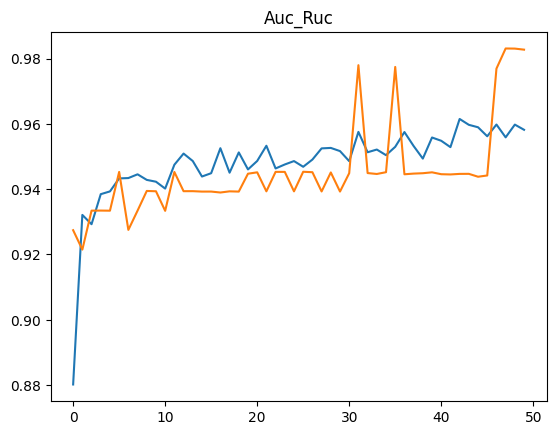

In [56]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title("Auc_Ruc")

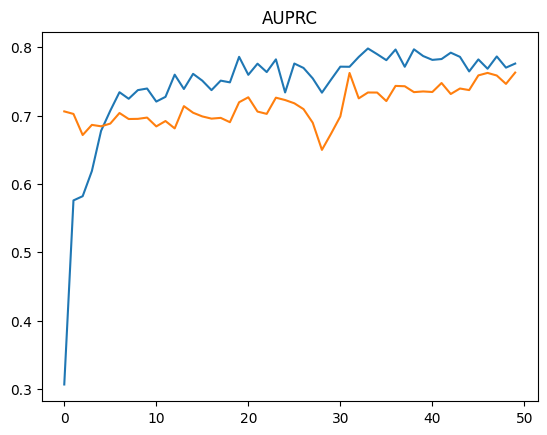

In [57]:
plt.title("AUPRC")
plt.plot(history.history['auprc'])
plt.plot(history.history['val_auprc'])

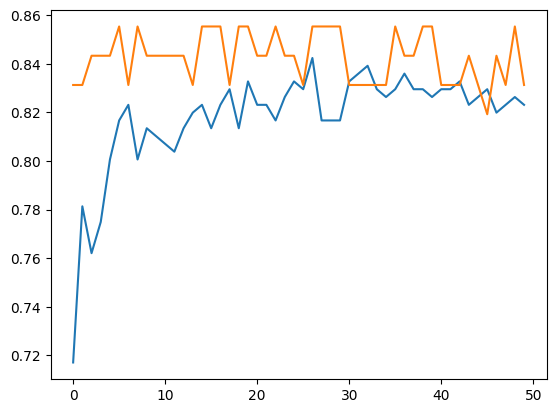

In [58]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

In [59]:
meta_X_train.shape

(227845, 2)

In [60]:
meta_X_test=np.column_stack((y_pred_proba_xgb, y_pred_proba_lgb))
meta_X_test.shape

(56962, 2)

In [61]:
meta_X_test=scaler.transform(meta_X_test)

In [62]:
#predict through meta model
y_pred_prob_nn = model.predict(meta_X_test).ravel()
y_pred_nn = (y_pred_prob_nn > 0.50).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# ROC-AUC
roc_auc_nn = roc_auc_score(y_test, y_pred_prob_nn)
print(f"ROC-AUC Score:{roc_auc_nn:.4f}")

# Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_nn)
auprc_nn= auc(recall, precision)
print(f"AUPRC Score: {auprc_nn:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.86      0.84        98

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56846    18]
 [   14    84]]
ROC-AUC Score:0.9768
AUPRC Score: 0.7772


In [44]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, auc, accuracy_score, precision_score, 
    recall_score, f1_score
)

y_pred_prob_nn = model.predict(meta_X_test).ravel()
y_pred_nn = (y_pred_prob_nn > 0.50).astype(int)

# Classification Report & Confusion Matrix
print("Classification Report:\n", classification_report(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# Individual Metrics
accuracy = accuracy_score(y_test, y_pred_nn)
precision = precision_score(y_test, y_pred_nn)
recall = recall_score(y_test, y_pred_nn)
f1 = f1_score(y_test, y_pred_nn)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# ROC-AUC
roc_auc_nn = roc_auc_score(y_test, y_pred_prob_nn)
print(f"ROC-AUC Score: {roc_auc_nn:.4f}")

# Precision-Recall AUC
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_prob_nn)
auprc_nn = auc(recall_vals, precision_vals)
print(f"AUPRC Score:   {auprc_nn:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56840    24]
 [   14    84]]
Accuracy:  0.9993
Precision: 0.7778
Recall:    0.8571
F1-Score:  0.8155
ROC-AUC Score: 0.9770
AUPRC Score:   0.8297


In [ ]:
y_pred_prob_nn = model.predict(meta_X_test).ravel()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_nn)

# Add edge thresholds (0 and 1)
thresholds = np.append(thresholds, [0,1])

best_threshold = 0.5
best_f1 = 0

# Search for best threshold
for t in thresholds:
    y_pred = (y_pred_prob_nn >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best threshold (F1-based on PR curve):", best_threshold)
print("Best F1 score:", best_f1)
print("Average Precision (AUPRC):", average_precision_score(y_test, y_pred_prob_nn))

In [ ]:
# Extract fraud cases
fraud_probs = y_pred_prob_nn[y_test == 1]

# Put into a DataFrame for clarity
fraud_df = pd.DataFrame({
    "Fraud_Prob": fraud_probs
}).sort_values("Fraud_Prob", ascending=False).reset_index(drop=True)

print(fraud_df.head(20))   # top 20 highest fraud probabilities
print("\nFraud probability stats:")
print(fraud_df.describe())

In [ ]:
fraud_probs = y_pred_prob_nn[y_test == 1]
nonfraud_probs = y_pred_prob_nn[y_test == 0]

plt.figure(figsize=(8,6))

# Plot histograms
plt.hist(nonfraud_probs, bins=50, alpha=0.6, label="Non-Fraud (Class 0)", color="blue", density=True)
plt.hist(fraud_probs, bins=50, alpha=0.6, label="Fraud (Class 1)", color="red", density=True)

# Labels and legend
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities for Fraud vs Non-Fraud")
plt.legend()
plt.show()

In [ ]:
#tuned hyperparamter neural network

In [ ]:
meta_training=pd.DataFrame(meta_X_train, meta_y_train)

In [ ]:
meta_training.head()

In [ ]:
meta_df = pd.DataFrame(meta_X_train, columns=[f"meta_feature_{i}" for i in range(meta_X_train.shape[1])])


meta_df["target"] = meta_y_train
meta_df.to_csv("meta_train.csv", index=False)

print(meta_df.head())


In [63]:
fraud = df[df["Class"] == 1]
non_fraud = df[df["Class"] == 0]


fraud_sample = fraud.sample(n=50, random_state=42)
non_fraud_sample = non_fraud.sample(n=950, random_state=42)

balanced_sample = pd.concat([fraud_sample, non_fraud_sample])

# Shuffle the rows
balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# Drop the target column
balanced_sample_no_target = balanced_sample.drop(columns=["Class"])
balanced_sample_no_target.to_csv("sample_data.csv", index=False)